In [1]:
from data_reader import DataReader
import datasets
from tweet_to_vec import TweetToVec
import utils
from RNN import RNNModel
from evaluate import evaluate1
from evaluate import evaluate2
import os
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
import numpy as np
from torch import nn, optim
import torch.nn as nn

In [2]:
dr = DataReader('nlkt')
dr.read_dataset(datasets.binary_classes, False)
dr.read_dataset(datasets.ternary_classes, False)
embeddings = dr.read_embeddings('embeddings/kraby.txt', False)

binary_dataset = dr.get_dataset('binary')
binary_dataset = utils.extract_validation_from_training(binary_dataset)

ternary_dataset = dr.get_dataset('ternary')
ternary_dataset = utils.extract_validation_from_training(ternary_dataset)

In [3]:
def test(dataset, epochs, method, L, size, num_layers, prediction_method, equalize_training_classes, learning_rate, number_of_output_classes):
    batch_size = 32
    t2v = TweetToVec(embeddings, method, L)

    if equalize_training_classes:
        dataset = utils.equalize_training_classes(dataset)
    vectorized_dataset = t2v.vectorize_dataset(dataset)
    def gen_batched():
        batched_dataset = t2v.batch_dataset(vectorized_dataset, batch_size, True, True)
        return batched_dataset['training tweets'], batched_dataset['training tags']

    model = RNNModel(size=size, embedding_dim=100,num_layers=num_layers, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=learning_rate)

    batched = t2v.batch_dataset(vectorized_dataset, batch_size, True, False)
    tweets = batched['validation tweets']
    tags = batched['validation tags']
    current_best_score = 0
    best_model_path = ""
    params_string = f'_number_of_output_classes_{number_of_output_classes}_method_{method}_L_{L}_size_{size}_num_layers_{num_layers}_prediction_method_{prediction_method}_equalize_training_classes_{equalize_training_classes}_learnig_rate_{learning_rate}'
    
    scores = []

    for i in range(epochs):
        model.train_model(gen_batched, 1)
        model.eval()
        predictions = model.predict(tweets)
        score = 0
        if number_of_output_classes == 2:
            score = evaluate1(predictions, tags)['balancedf']
            print(" balancedf score on valid =", score)
        else:
            score = evaluate2(predictions, tags)['microAverageFscore']
            print(" microAverageFscore score on valid =", score)  
        scores.append(score)  
        if score > current_best_score:
            if len(best_model_path) > 0:
                os.remove(best_model_path)
            current_best_score = score
            str_score = str(score * 100)
            str_score = str_score[:min(len(str_score), 5)]
            best_model_path = 'models/RNN_' + str_score + params_string + '.model'
            torch.save(model.state_dict(), best_model_path)
    

    plt.plot(scores)
    plt.ylabel('scores on validation over epochs')
    plt.show()
    print("Best score = ", current_best_score)

In [4]:
def evaluate_on_test(filename, dataset, size, num_layers, L, prediction_method, method, number_of_output_classes):
    model = RNNModel(size=size, embedding_dim=100,num_layers=num_layers, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=0.0001)
    model.load_state_dict(torch.load(filename))
    model.eval()

    t2v = TweetToVec(embeddings, method, L)
    
    vectorized_dataset = t2v.vectorize_dataset(dataset)

    batched = t2v.batch_dataset(vectorized_dataset, 1, True, False)
    tweets = batched['test tweets']
    tags = batched['test tags']

    predictions = model.predict(tweets)
    if number_of_output_classes == 2:
        score = evaluate1(predictions, tags)['balancedf']
        print(" balancedf score on test =", score)
    else:
        score = evaluate2(predictions, tags)['microAverageFscore']
        print(" microAverageFscore score on test =", score)

## Hyperparameters tuning of RNN on binary problem

### First round of hyperparameters turning

After epoch 0 tot_loss = 250.5773162841797 balancedf score on valid = 0.37944664031620556
After epoch 1 tot_loss = 210.5731658935547 balancedf score on valid = 0.38181818181818183
After epoch 2 tot_loss = 178.2368927001953 balancedf score on valid = 0.43171806167400884
After epoch 3 tot_loss = 126.22176361083984 balancedf score on valid = 0.43243243243243246
After epoch 4 tot_loss = 80.55352783203125 balancedf score on valid = 0.4296875
After epoch 5 tot_loss = 55.24998092651367 balancedf score on valid = 0.4152542372881356
After epoch 6 tot_loss = 38.64226150512695 balancedf score on valid = 0.48554913294797686
After epoch 7 tot_loss = 27.66400146484375 balancedf score on valid = 0.43537414965986393
After epoch 8 tot_loss = 20.664030075073242 balancedf score on valid = 0.41818181818181815
After epoch 9 tot_loss = 18.2366943359375 balancedf score on valid = 0.38735177865612647
After epoch 10 tot_loss = 14.357829093933105 balancedf score on valid = 0.4739884393063584
After epoch 11 tot_

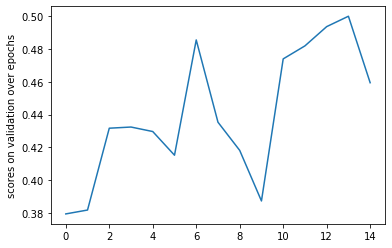

Best score =  0.5


In [5]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 203.57640075683594 balancedf score on valid = 0.42666666666666675
After epoch 1 tot_loss = 129.44178771972656 balancedf score on valid = 0.4148148148148148
After epoch 2 tot_loss = 90.70486450195312 balancedf score on valid = 0.46636771300448426
After epoch 3 tot_loss = 66.87290954589844 balancedf score on valid = 0.4519774011299435
After epoch 4 tot_loss = 47.400360107421875 balancedf score on valid = 0.4725274725274725
After epoch 5 tot_loss = 33.9831428527832 balancedf score on valid = 0.4425531914893616
After epoch 6 tot_loss = 21.61771583557129 balancedf score on valid = 0.39999999999999997
After epoch 7 tot_loss = 14.953354835510254 balancedf score on valid = 0.44919786096256686
After epoch 8 tot_loss = 12.617230415344238 balancedf score on valid = 0.4606741573033708
After epoch 9 tot_loss = 8.363001823425293 balancedf score on valid = 0.47513812154696133
After epoch 10 tot_loss = 7.730446815490723 balancedf score on valid = 0.4444444444444444
After epoch

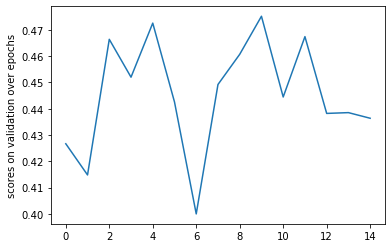

Best score =  0.47513812154696133


In [6]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d',
     L=30, 
     size=512, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 206.320068359375 balancedf score on valid = 0.41420118343195267
After epoch 1 tot_loss = 113.69679260253906 balancedf score on valid = 0.4330708661417323
After epoch 2 tot_loss = 60.39329147338867 balancedf score on valid = 0.5
After epoch 3 tot_loss = 42.00974655151367 balancedf score on valid = 0.5023696682464455
After epoch 4 tot_loss = 23.584592819213867 balancedf score on valid = 0.4824120603015076
After epoch 5 tot_loss = 14.126965522766113 balancedf score on valid = 0.5341614906832298
After epoch 6 tot_loss = 11.001150131225586 balancedf score on valid = 0.4774193548387097
After epoch 7 tot_loss = 5.79373836517334 balancedf score on valid = 0.46625766871165647
After epoch 8 tot_loss = 3.077784776687622 balancedf score on valid = 0.4275862068965517
After epoch 9 tot_loss = 14.796568870544434 balancedf score on valid = 0.4812834224598931
After epoch 10 tot_loss = 5.696566581726074 balancedf score on valid = 0.5185185185185186
After epoch 11 tot_loss = 1.27

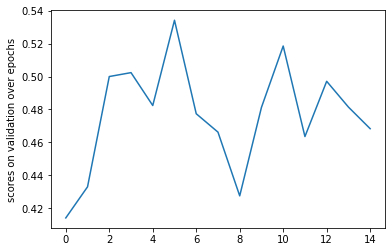

Best score =  0.5341614906832298


In [7]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 252.61741638183594 balancedf score on valid = 0.359375
After epoch 1 tot_loss = 206.7262420654297 balancedf score on valid = 0.3818181818181818
After epoch 2 tot_loss = 176.15399169921875 balancedf score on valid = 0.3340659340659341
After epoch 3 tot_loss = 130.48716735839844 balancedf score on valid = 0.40138408304498263
After epoch 4 tot_loss = 89.9294204711914 balancedf score on valid = 0.4188034188034188
After epoch 5 tot_loss = 60.94811248779297 balancedf score on valid = 0.39072847682119205
After epoch 6 tot_loss = 40.45054244995117 balancedf score on valid = 0.41255605381165916
After epoch 7 tot_loss = 33.85700988769531 balancedf score on valid = 0.4313725490196078
After epoch 8 tot_loss = 21.38958168029785 balancedf score on valid = 0.4444444444444444
After epoch 9 tot_loss = 21.466556549072266 balancedf score on valid = 0.45
After epoch 10 tot_loss = 12.017382621765137 balancedf score on valid = 0.3930131004366812
After epoch 11 tot_loss = 13.73375988

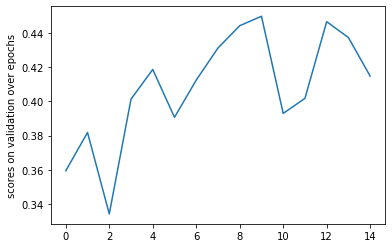

Best score =  0.45


In [8]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 281.9468994140625 balancedf score on valid = 0.39755351681957185
After epoch 1 tot_loss = 226.68638610839844 balancedf score on valid = 0.3742331288343558
After epoch 2 tot_loss = 206.193603515625 balancedf score on valid = 0.37988826815642457
After epoch 3 tot_loss = 189.69981384277344 balancedf score on valid = 0.4115755627009647
After epoch 4 tot_loss = 173.3361053466797 balancedf score on valid = 0.40816326530612246
After epoch 5 tot_loss = 154.21617126464844 balancedf score on valid = 0.4497991967871486
After epoch 6 tot_loss = 133.60116577148438 balancedf score on valid = 0.3999999999999999
After epoch 7 tot_loss = 116.28756713867188 balancedf score on valid = 0.45643153526970953
After epoch 8 tot_loss = 96.06119537353516 balancedf score on valid = 0.45669291338582674
After epoch 9 tot_loss = 81.40705108642578 balancedf score on valid = 0.4426229508196721
After epoch 10 tot_loss = 67.811767578125 balancedf score on valid = 0.45098039215686275
After epoch 

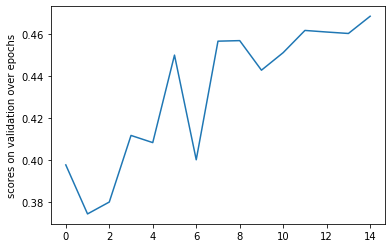

Best score =  0.4682926829268293


In [9]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

### Second iterations round (small changes of the best from the previous round)

After epoch 0 tot_loss = 204.04901123046875 balancedf score on valid = 0.391025641025641
After epoch 1 tot_loss = 117.11746215820312 balancedf score on valid = 0.4462809917355372
After epoch 2 tot_loss = 67.64680480957031 balancedf score on valid = 0.42512077294685985
After epoch 3 tot_loss = 43.28581237792969 balancedf score on valid = 0.4725274725274725
After epoch 4 tot_loss = 24.440195083618164 balancedf score on valid = 0.45555555555555555
After epoch 5 tot_loss = 19.832765579223633 balancedf score on valid = 0.47513812154696133
After epoch 6 tot_loss = 9.751155853271484 balancedf score on valid = 0.4563106796116505
After epoch 7 tot_loss = 13.219355583190918 balancedf score on valid = 0.44943820224719094
After epoch 8 tot_loss = 7.251154899597168 balancedf score on valid = 0.4585987261146497
After epoch 9 tot_loss = 4.759616851806641 balancedf score on valid = 0.5088757396449705
After epoch 10 tot_loss = 2.35355544090271 balancedf score on valid = 0.4727272727272728
After epoch 1

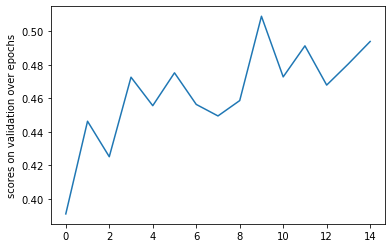

Best score =  0.5088757396449705


In [5]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0005,
     number_of_output_classes=2)

After epoch 0 tot_loss = 252.75079345703125 balancedf score on valid = 0.3834808259587021
After epoch 1 tot_loss = 174.3133544921875 balancedf score on valid = 0.437037037037037
After epoch 2 tot_loss = 132.28604125976562 balancedf score on valid = 0.4701195219123506
After epoch 3 tot_loss = 100.28131866455078 balancedf score on valid = 0.4730290456431535
After epoch 4 tot_loss = 75.635498046875 balancedf score on valid = 0.44194756554307113
After epoch 5 tot_loss = 58.563602447509766 balancedf score on valid = 0.4690265486725664
After epoch 6 tot_loss = 44.138824462890625 balancedf score on valid = 0.4200913242009133
After epoch 7 tot_loss = 34.47416687011719 balancedf score on valid = 0.4838709677419355
After epoch 8 tot_loss = 26.49626350402832 balancedf score on valid = 0.47761194029850745
After epoch 9 tot_loss = 21.683582305908203 balancedf score on valid = 0.47727272727272724
After epoch 10 tot_loss = 16.8999080657959 balancedf score on valid = 0.4756756756756757
After epoch 11 

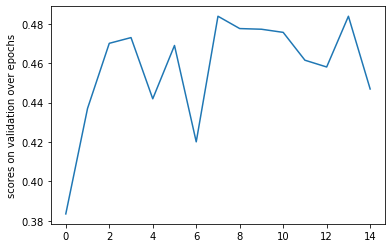

Best score =  0.4838709677419355


In [6]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 231.357177734375 balancedf score on valid = 0.401294498381877
After epoch 1 tot_loss = 155.31173706054688 balancedf score on valid = 0.42033898305084744
After epoch 2 tot_loss = 112.53211212158203 balancedf score on valid = 0.41401273885350315
After epoch 3 tot_loss = 93.54932403564453 balancedf score on valid = 0.4608695652173913
After epoch 4 tot_loss = 68.11229705810547 balancedf score on valid = 0.44166666666666665
After epoch 5 tot_loss = 67.14530181884766 balancedf score on valid = 0.4497991967871486
After epoch 6 tot_loss = 52.89705276489258 balancedf score on valid = 0.43523316062176165
After epoch 7 tot_loss = 51.40742492675781 balancedf score on valid = 0.47488584474885837
After epoch 8 tot_loss = 42.294315338134766 balancedf score on valid = 0.47115384615384615
After epoch 9 tot_loss = 40.66401290893555 balancedf score on valid = 0.5054945054945055
After epoch 10 tot_loss = 27.001501083374023 balancedf score on valid = 0.5454545454545454
After epoch 

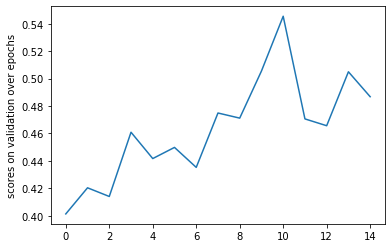

Best score =  0.5454545454545454


In [7]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=2)

After epoch 0 tot_loss = 358.1253356933594 balancedf score on valid = 0.1899827288428325
After epoch 1 tot_loss = 343.2115783691406 balancedf score on valid = 0.18436873747494992
After epoch 2 tot_loss = 323.0831298828125 balancedf score on valid = 0.15555555555555556
After epoch 3 tot_loss = 301.14349365234375 balancedf score on valid = 0.14864864864864866
After epoch 4 tot_loss = 272.5809326171875 balancedf score on valid = 0.145
After epoch 5 tot_loss = 241.12428283691406 balancedf score on valid = 0.1273209549071618
After epoch 6 tot_loss = 206.7327880859375 balancedf score on valid = 0.13043478260869568
After epoch 7 tot_loss = 171.52552795410156 balancedf score on valid = 0.12389380530973451
After epoch 8 tot_loss = 137.0986328125 balancedf score on valid = 0.11838006230529596
After epoch 9 tot_loss = 112.628173828125 balancedf score on valid = 0.1310344827586207
After epoch 10 tot_loss = 89.69464874267578 balancedf score on valid = 0.12605042016806725
After epoch 11 tot_loss = 7

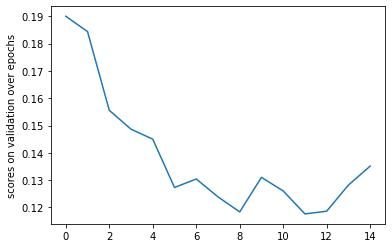

Best score =  0.1899827288428325


In [8]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3,
     prediction_method='last',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 289.9111022949219 balancedf score on valid = 0.4
After epoch 1 tot_loss = 212.41836547851562 balancedf score on valid = 0.35121951219512193
After epoch 2 tot_loss = 184.9019775390625 balancedf score on valid = 0.40840840840840836
After epoch 3 tot_loss = 163.2721710205078 balancedf score on valid = 0.44128113879003555
After epoch 4 tot_loss = 142.45436096191406 balancedf score on valid = 0.43986254295532645
After epoch 5 tot_loss = 122.33213806152344 balancedf score on valid = 0.45614035087719296
After epoch 6 tot_loss = 106.29682922363281 balancedf score on valid = 0.484375
After epoch 7 tot_loss = 93.02657318115234 balancedf score on valid = 0.4765625000000001
After epoch 8 tot_loss = 81.9754638671875 balancedf score on valid = 0.4671532846715329
After epoch 9 tot_loss = 72.33086395263672 balancedf score on valid = 0.48571428571428565
After epoch 10 tot_loss = 64.09819030761719 balancedf score on valid = 0.4568965517241379
After epoch 11 tot_loss = 57.9142227

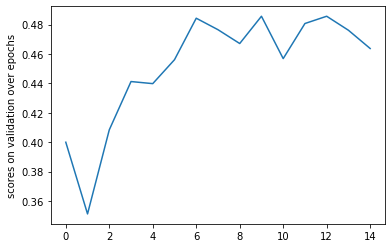

Best score =  0.48571428571428565


In [9]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 345.6768493652344 balancedf score on valid = 0.2827004219409283
After epoch 1 tot_loss = 269.1259460449219 balancedf score on valid = 0.3775510204081633
After epoch 2 tot_loss = 226.73007202148438 balancedf score on valid = 0.39444444444444443
After epoch 3 tot_loss = 206.91934204101562 balancedf score on valid = 0.4036144578313253
After epoch 4 tot_loss = 193.4225616455078 balancedf score on valid = 0.4119402985074627
After epoch 5 tot_loss = 181.46383666992188 balancedf score on valid = 0.41764705882352937
After epoch 6 tot_loss = 170.96453857421875 balancedf score on valid = 0.4465408805031446
After epoch 7 tot_loss = 161.34678649902344 balancedf score on valid = 0.4423076923076923
After epoch 8 tot_loss = 152.7346954345703 balancedf score on valid = 0.4573378839590444
After epoch 9 tot_loss = 145.44223022460938 balancedf score on valid = 0.4604810996563574
After epoch 10 tot_loss = 138.43777465820312 balancedf score on valid = 0.4631578947368421
After epoch

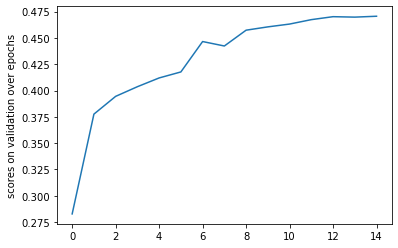

Best score =  0.47058823529411775


In [10]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=32, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 250.7801055908203 balancedf score on valid = 0.3878787878787879
After epoch 1 tot_loss = 172.53860473632812 balancedf score on valid = 0.42402826855123676
After epoch 2 tot_loss = 130.09310913085938 balancedf score on valid = 0.4603773584905661
After epoch 3 tot_loss = 98.08292388916016 balancedf score on valid = 0.48214285714285715
After epoch 4 tot_loss = 73.11226654052734 balancedf score on valid = 0.5067873303167421
After epoch 5 tot_loss = 56.36068344116211 balancedf score on valid = 0.5045871559633027
After epoch 6 tot_loss = 43.096046447753906 balancedf score on valid = 0.5483870967741935
After epoch 7 tot_loss = 34.07128143310547 balancedf score on valid = 0.5142857142857143
After epoch 8 tot_loss = 26.314363479614258 balancedf score on valid = 0.4971751412429378
After epoch 9 tot_loss = 21.527606964111328 balancedf score on valid = 0.496969696969697
After epoch 10 tot_loss = 15.887890815734863 balancedf score on valid = 0.5
After epoch 11 tot_loss = 15

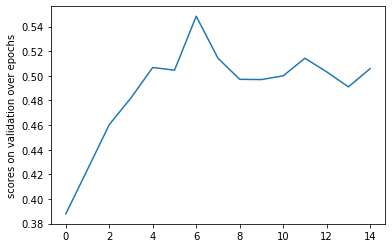

Best score =  0.5483870967741935


In [11]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=4,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

### Final tuning

After epoch 0 tot_loss = 257.0003662109375 balancedf score on valid = 0.35795454545454547
After epoch 1 tot_loss = 236.31495666503906 balancedf score on valid = 0.39755351681957185
After epoch 2 tot_loss = 184.95388793945312 balancedf score on valid = 0.40404040404040403
After epoch 3 tot_loss = 143.87078857421875 balancedf score on valid = 0.3812709030100334
After epoch 4 tot_loss = 111.41807556152344 balancedf score on valid = 0.42231075697211157
After epoch 5 tot_loss = 103.53834533691406 balancedf score on valid = 0.45581395348837206
After epoch 6 tot_loss = 101.3231430053711 balancedf score on valid = 0.3972125435540069
After epoch 7 tot_loss = 90.1241683959961 balancedf score on valid = 0.47533632286995514
After epoch 8 tot_loss = 73.78550720214844 balancedf score on valid = 0.4705882352941176
After epoch 9 tot_loss = 71.29717254638672 balancedf score on valid = 0.44660194174757284
After epoch 10 tot_loss = 62.22404479980469 balancedf score on valid = 0.4684684684684684
After epo

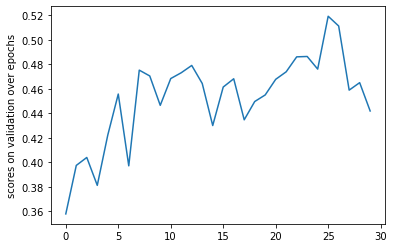

Best score =  0.5193370165745856


In [12]:
test(dataset=binary_dataset, 
     epochs=30,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=4,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=2)

After epoch 0 tot_loss = 217.7675018310547 balancedf score on valid = 0.402555910543131
After epoch 1 tot_loss = 132.57679748535156 balancedf score on valid = 0.4222222222222222
After epoch 2 tot_loss = 91.41963195800781 balancedf score on valid = 0.4285714285714286
After epoch 3 tot_loss = 64.60411834716797 balancedf score on valid = 0.4460431654676259
After epoch 4 tot_loss = 49.69282913208008 balancedf score on valid = 0.49214659685863876
After epoch 5 tot_loss = 37.23466110229492 balancedf score on valid = 0.4581005586592179
After epoch 6 tot_loss = 27.28597640991211 balancedf score on valid = 0.4682926829268293
After epoch 7 tot_loss = 24.931346893310547 balancedf score on valid = 0.45652173913043476
After epoch 8 tot_loss = 16.96980857849121 balancedf score on valid = 0.4725274725274725
After epoch 9 tot_loss = 14.647546768188477 balancedf score on valid = 0.44943820224719094
After epoch 10 tot_loss = 11.637067794799805 balancedf score on valid = 0.4606741573033708
After epoch 11

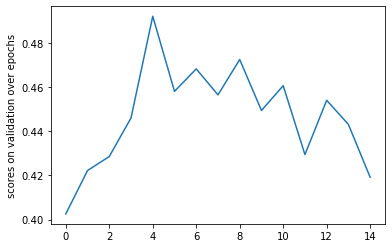

Best score =  0.49214659685863876


In [6]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=32, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 264.9571533203125 balancedf score on valid = 0.34828496042216356
After epoch 1 tot_loss = 195.54434204101562 balancedf score on valid = 0.39039039039039036
After epoch 2 tot_loss = 120.19705963134766 balancedf score on valid = 0.3870967741935483
After epoch 3 tot_loss = 75.89080047607422 balancedf score on valid = 0.4214876033057851
After epoch 4 tot_loss = 42.6065788269043 balancedf score on valid = 0.4827586206896552
After epoch 5 tot_loss = 34.62196731567383 balancedf score on valid = 0.4074074074074074
After epoch 6 tot_loss = 17.50092315673828 balancedf score on valid = 0.4713375796178344
After epoch 7 tot_loss = 16.26476287841797 balancedf score on valid = 0.46226415094339623
After epoch 8 tot_loss = 6.891894340515137 balancedf score on valid = 0.48863636363636365
After epoch 9 tot_loss = 4.051870822906494 balancedf score on valid = 0.5234899328859061


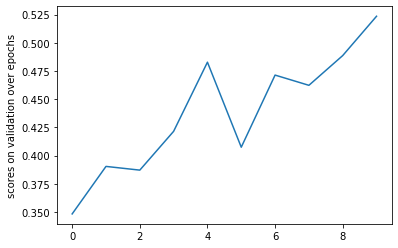

Best score =  0.5234899328859061


In [7]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=512, 
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0003,
     number_of_output_classes=2)

### Evaluation of the best RNN model on binary problem

In [14]:
evaluate_on_test('models/RNN_47.05_number_of_output_classes_2_method_fixed_length_2d_L_30_size_32_num_layers_3_prediction_method_max_equalize_training_classes_True_learnig_rate_0.0001.model',                 
                 dataset=binary_dataset,
                 size=32,
                 num_layers=3,
                 L=30,
                 prediction_method='max',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.5065789473684211


## Hyperparameters tuning of RNN on ternary problem

### First iteration

After epoch 0 tot_loss = 747.3309936523438 microAverageFscore score on valid = 0.6274900398406374
After epoch 1 tot_loss = 485.7969665527344 microAverageFscore score on valid = 0.6603585657370518
After epoch 2 tot_loss = 317.87652587890625 microAverageFscore score on valid = 0.7828685258964143
After epoch 3 tot_loss = 298.2549743652344 microAverageFscore score on valid = 0.7280876494023905
After epoch 4 tot_loss = 307.5887145996094 microAverageFscore score on valid = 0.7480079681274902
After epoch 5 tot_loss = 294.5321044921875 microAverageFscore score on valid = 0.7878486055776892
After epoch 6 tot_loss = 301.58984375 microAverageFscore score on valid = 0.7529880478087649
After epoch 7 tot_loss = 300.4393615722656 microAverageFscore score on valid = 0.8037848605577689
After epoch 8 tot_loss = 277.6090087890625 microAverageFscore score on valid = 0.7739043824701194
After epoch 9 tot_loss = 238.10096740722656 microAverageFscore score on valid = 0.7679282868525896


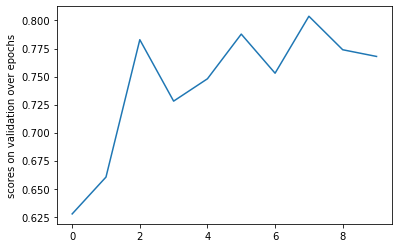

Best score =  0.8037848605577689


In [5]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=4,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

After epoch 0 tot_loss = 423.99237060546875 microAverageFscore score on valid = 0.8366533864541833
After epoch 1 tot_loss = 277.394287109375 microAverageFscore score on valid = 0.8276892430278886
After epoch 2 tot_loss = 193.8173065185547 microAverageFscore score on valid = 0.8555776892430279
After epoch 3 tot_loss = 187.85182189941406 microAverageFscore score on valid = 0.8286852589641436
After epoch 4 tot_loss = 149.4749755859375 microAverageFscore score on valid = 0.795816733067729
After epoch 5 tot_loss = 231.87413024902344 microAverageFscore score on valid = 0.6782868525896414
After epoch 6 tot_loss = 206.67877197265625 microAverageFscore score on valid = 0.8077689243027888
After epoch 7 tot_loss = 136.9882049560547 microAverageFscore score on valid = 0.8466135458167331
After epoch 8 tot_loss = 220.54092407226562 microAverageFscore score on valid = 0.7808764940239044
After epoch 9 tot_loss = 139.74618530273438 microAverageFscore score on valid = 0.8426294820717132


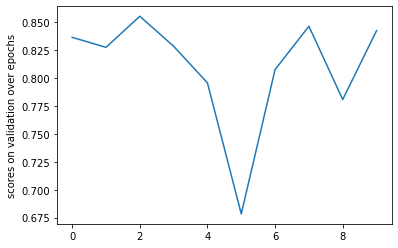

Best score =  0.8555776892430279


In [6]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

### Second iteration

After epoch 0 tot_loss = 707.6174926757812 microAverageFscore score on valid = 0.6713147410358565
After epoch 1 tot_loss = 454.69171142578125 microAverageFscore score on valid = 0.6254980079681275
After epoch 2 tot_loss = 378.9260559082031 microAverageFscore score on valid = 0.7739043824701194
After epoch 3 tot_loss = 380.58355712890625 microAverageFscore score on valid = 0.7260956175298804
After epoch 4 tot_loss = 356.45086669921875 microAverageFscore score on valid = 0.7599601593625498
After epoch 5 tot_loss = 319.4284362792969 microAverageFscore score on valid = 0.750996015936255
After epoch 6 tot_loss = 287.98541259765625 microAverageFscore score on valid = 0.7609561752988048
After epoch 7 tot_loss = 304.54254150390625 microAverageFscore score on valid = 0.7181274900398407


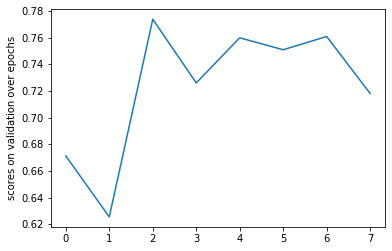

Best score =  0.7739043824701194


In [7]:
test(dataset=ternary_dataset, 
     epochs=8,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

After epoch 0 tot_loss = 459.6790466308594 microAverageFscore score on valid = 0.7719123505976095
After epoch 1 tot_loss = 203.36865234375 microAverageFscore score on valid = 0.8017928286852589
After epoch 2 tot_loss = 255.0964813232422 microAverageFscore score on valid = 0.799800796812749
After epoch 3 tot_loss = 349.6826171875 microAverageFscore score on valid = 0.7569721115537849
After epoch 4 tot_loss = 259.9398193359375 microAverageFscore score on valid = 0.7918326693227091
After epoch 5 tot_loss = 239.6957244873047 microAverageFscore score on valid = 0.7758964143426295
After epoch 6 tot_loss = 240.9620819091797 microAverageFscore score on valid = 0.7908366533864541
After epoch 7 tot_loss = 207.23867797851562 microAverageFscore score on valid = 0.8007968127490039
After epoch 8 tot_loss = 242.99746704101562 microAverageFscore score on valid = 0.8217131474103586
After epoch 9 tot_loss = 215.11538696289062 microAverageFscore score on valid = 0.7948207171314741


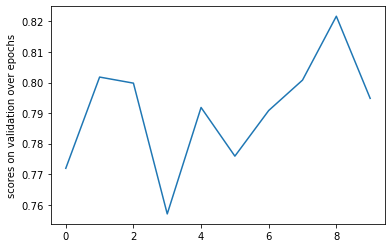

Best score =  0.8217131474103586


In [8]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=4,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

After epoch 0 tot_loss = 490.1382141113281 microAverageFscore score on valid = 0.8247011952191236
After epoch 1 tot_loss = 204.61279296875 microAverageFscore score on valid = 0.7918326693227091
After epoch 2 tot_loss = 217.1957550048828 microAverageFscore score on valid = 0.7211155378486057
After epoch 3 tot_loss = 186.24627685546875 microAverageFscore score on valid = 0.7788844621513945
After epoch 4 tot_loss = 135.02520751953125 microAverageFscore score on valid = 0.8306772908366534
After epoch 5 tot_loss = 138.53138732910156 microAverageFscore score on valid = 0.8097609561752988
After epoch 6 tot_loss = 119.35671997070312 microAverageFscore score on valid = 0.8187250996015937
After epoch 7 tot_loss = 131.42469787597656 microAverageFscore score on valid = 0.8376494023904383
After epoch 8 tot_loss = 103.59944915771484 microAverageFscore score on valid = 0.8296812749003984
After epoch 9 tot_loss = 125.7869644165039 microAverageFscore score on valid = 0.853585657370518


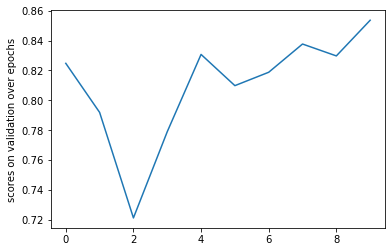

Best score =  0.853585657370518


In [9]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

After epoch 0 tot_loss = 542.7631225585938 microAverageFscore score on valid = 0.7768924302788844
After epoch 1 tot_loss = 442.22259521484375 microAverageFscore score on valid = 0.5816733067729084
After epoch 2 tot_loss = 511.9891662597656 microAverageFscore score on valid = 0.7758964143426295
After epoch 3 tot_loss = 519.102783203125 microAverageFscore score on valid = 0.7320717131474104
After epoch 4 tot_loss = 691.4580078125 microAverageFscore score on valid = 0.6643426294820717
After epoch 5 tot_loss = 742.5848388671875 microAverageFscore score on valid = 0.6703187250996016
After epoch 6 tot_loss = 800.2425537109375 microAverageFscore score on valid = 0.5398406374501992
After epoch 7 tot_loss = 858.9320068359375 microAverageFscore score on valid = 0.6743027888446215
After epoch 8 tot_loss = 811.3935546875 microAverageFscore score on valid = 0.8406374501992032
After epoch 9 tot_loss = 836.4049072265625 microAverageFscore score on valid = 0.5826693227091634


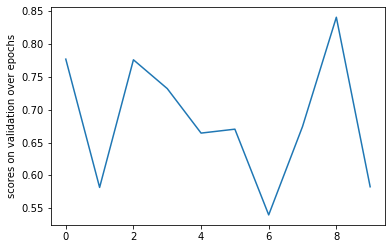

Best score =  0.8406374501992032


In [10]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.01,
     number_of_output_classes=3)

After epoch 0 tot_loss = 750.0148315429688 microAverageFscore score on valid = 0.499003984063745
After epoch 1 tot_loss = 613.5604248046875 microAverageFscore score on valid = 0.6563745019920318
After epoch 2 tot_loss = 422.2427673339844 microAverageFscore score on valid = 0.6573705179282868
After epoch 3 tot_loss = 383.05609130859375 microAverageFscore score on valid = 0.5966135458167331
After epoch 4 tot_loss = 351.7747497558594 microAverageFscore score on valid = 0.745019920318725
After epoch 5 tot_loss = 359.816162109375 microAverageFscore score on valid = 0.7749003984063744
After epoch 6 tot_loss = 326.1796569824219 microAverageFscore score on valid = 0.7649402390438247
After epoch 7 tot_loss = 359.152587890625 microAverageFscore score on valid = 0.7280876494023905
After epoch 8 tot_loss = 351.59393310546875 microAverageFscore score on valid = 0.7290836653386454
After epoch 9 tot_loss = 330.9508972167969 microAverageFscore score on valid = 0.6972111553784861


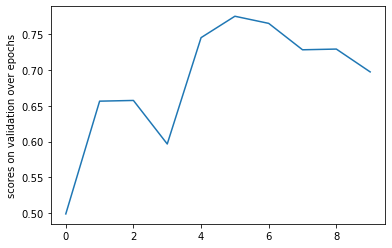

Best score =  0.7749003984063744


In [14]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=4,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

After epoch 0 tot_loss = 890.9476928710938 microAverageFscore score on valid = 0.37350597609561753
After epoch 1 tot_loss = 740.2257080078125 microAverageFscore score on valid = 0.5199203187250996
After epoch 2 tot_loss = 758.0879516601562 microAverageFscore score on valid = 0.449203187250996
After epoch 3 tot_loss = 847.5933227539062 microAverageFscore score on valid = 0.4591633466135458
After epoch 4 tot_loss = 600.1253051757812 microAverageFscore score on valid = 0.6623505976095617
After epoch 5 tot_loss = 594.3394165039062 microAverageFscore score on valid = 0.5209163346613546
After epoch 6 tot_loss = 604.3015747070312 microAverageFscore score on valid = 0.5587649402390438
After epoch 7 tot_loss = 505.5131530761719 microAverageFscore score on valid = 0.6573705179282868
After epoch 8 tot_loss = 418.7093505859375 microAverageFscore score on valid = 0.6165338645418327
After epoch 9 tot_loss = 352.6669616699219 microAverageFscore score on valid = 0.75


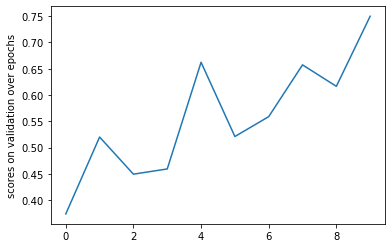

Best score =  0.75


In [15]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=3)

After epoch 0 tot_loss = 560.9813232421875 microAverageFscore score on valid = 0.7758964143426295
After epoch 1 tot_loss = 512.7645874023438 microAverageFscore score on valid = 0.7300796812749004
After epoch 2 tot_loss = 532.7879638671875 microAverageFscore score on valid = 0.6613545816733067
After epoch 3 tot_loss = 707.8151245117188 microAverageFscore score on valid = 0.41733067729083667
After epoch 4 tot_loss = 731.97607421875 microAverageFscore score on valid = 0.5089641434262948
After epoch 5 tot_loss = 691.424072265625 microAverageFscore score on valid = 0.6205179282868526
After epoch 6 tot_loss = 633.4523315429688 microAverageFscore score on valid = 0.6573705179282868
After epoch 7 tot_loss = 598.0711059570312 microAverageFscore score on valid = 0.6633466135458167
After epoch 8 tot_loss = 526.0107421875 microAverageFscore score on valid = 0.7758964143426295
After epoch 9 tot_loss = 628.3446044921875 microAverageFscore score on valid = 0.598605577689243


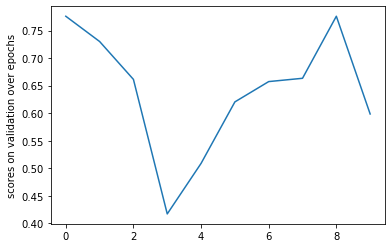

Best score =  0.7758964143426295


In [6]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=64, 
     num_layers=3,
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.01,
     number_of_output_classes=3)

After epoch 0 tot_loss = 1862.6524658203125 microAverageFscore score on valid = 0.28286852589641437
After epoch 1 tot_loss = 952.111083984375 microAverageFscore score on valid = 0.4153386454183267
After epoch 2 tot_loss = 995.1106567382812 microAverageFscore score on valid = 0.11852589641434264
After epoch 3 tot_loss = 1013.205322265625 microAverageFscore score on valid = 0.3336653386454183
After epoch 4 tot_loss = 846.8770141601562 microAverageFscore score on valid = 0.6673306772908366
After epoch 5 tot_loss = 725.4763793945312 microAverageFscore score on valid = 0.30378486055776893
After epoch 6 tot_loss = 794.2308959960938 microAverageFscore score on valid = 0.5697211155378487
After epoch 7 tot_loss = 858.6272583007812 microAverageFscore score on valid = 0.5756972111553785
After epoch 8 tot_loss = 1129.1602783203125 microAverageFscore score on valid = 0.060756972111553786
After epoch 9 tot_loss = 4954.99951171875 microAverageFscore score on valid = 0.6633466135458167


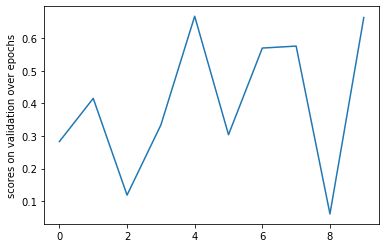

Best score =  0.6673306772908366


In [7]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2,
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.01,
     number_of_output_classes=3)

## Evaluate best solutions on ternary problem

In [11]:
evaluate_on_test('models/RNN_85.55_number_of_output_classes_3_method_fixed_length_2d_L_30_size_64_num_layers_3_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.005.model', 
                 dataset=ternary_dataset,
                 size=64,
                 num_layers=3,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=3)

 microAverageFscore score on test = 0.851
